In [2]:
from dotenv import load_dotenv
import pandas as pd
import os
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
load_dotenv()

True

In [3]:
DB_URL_BASE = os.getenv("DB_URI")
DB_NAME = "retail_demand_analysis"
RAW_SCHEMA_NAME = "retail_raw"
CURATED_SCHEMA_NAME = "retail_curated"

query = f"SELECT * FROM {CURATED_SCHEMA_NAME}.transactions"
engine = create_engine(f"{DB_URL_BASE}/{DB_NAME}")

base_df = pd.read_sql(con=engine, sql=query)
df = base_df.copy()

df.describe()

,quantity,invoicedate,unitprice,customer_id,revenue
count,407664.000000,407664,407664.000000,407664.000000,407664.000000
mean,13.585585,2010-07-01 10:15:11.871688448,3.294438,15368.592598,21.664909
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000,0.001000
25%,2.000000,2010-03-26 14:01:00,1.250000,13997.000000,4.950000
50%,5.000000,2010-07-09 15:47:00,1.950000,15321.000000,11.900000
75%,12.000000,2010-10-14 17:09:00,3.750000,16812.000000,19.500000
max,19152.000000,2010-12-09 20:01:00,10953.500000,18287.000000,15818.400000
std,96.840747,NaN,34.757965,1679.762138,77.150058


In [4]:
# helper functions

def to_postgres(df: pd.DataFrame, name):
    df.to_sql(name, con=engine, schema=CURATED_SCHEMA_NAME, if_exists="replace")


## Preprocessing the Data


In [5]:
SKU_items = df.copy().groupby(['stockcode']).agg({
    'description': "first"
})

# export SKUs into their own table
to_postgres(SKU_items, "sku_items")

if "description" in df.columns:
    df.drop(["description"], axis=1, inplace=True)

df.describe()

,quantity,invoicedate,unitprice,customer_id,revenue
count,407664.000000,407664,407664.000000,407664.000000,407664.000000
mean,13.585585,2010-07-01 10:15:11.871688448,3.294438,15368.592598,21.664909
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000,0.001000
25%,2.000000,2010-03-26 14:01:00,1.250000,13997.000000,4.950000
50%,5.000000,2010-07-09 15:47:00,1.950000,15321.000000,11.900000
75%,12.000000,2010-10-14 17:09:00,3.750000,16812.000000,19.500000
max,19152.000000,2010-12-09 20:01:00,10953.500000,18287.000000,15818.400000
std,96.840747,NaN,34.757965,1679.762138,77.150058


In [6]:
# Date format: 2009-12-02 12:13:00


if "invoicedate" in df.columns:
    df['invoicedate'] = pd.to_datetime(df['invoicedate'])
    df["year"] = df["invoicedate"].dt.year
    df["month"] = df["invoicedate"].dt.month
    df["week_year"] = df["invoicedate"].dt.isocalendar().week.astype(str) + "_" + df["year"].astype(str)
    df["weekday"] = df["invoicedate"].dt.day_name()

    df.drop(['invoicedate'], axis='columns', inplace=True)

df



,invoice,stockcode,quantity,unitprice,customer_id,country,revenue,year,month,week_year,weekday
0,489434,85048,12,6.95,13085.0,United Kingdom,83.40,2009,12,49_2009,Tuesday
1,489434,79323P,12,6.75,13085.0,United Kingdom,81.00,2009,12,49_2009,Tuesday
2,489434,79323W,12,6.75,13085.0,United Kingdom,81.00,2009,12,49_2009,Tuesday
3,489434,22041,48,2.10,13085.0,United Kingdom,100.80,2009,12,49_2009,Tuesday
4,489434,21232,24,1.25,13085.0,United Kingdom,30.00,2009,12,49_2009,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
407659,538171,22271,2,2.95,17530.0,United Kingdom,5.90,2010,12,49_2010,Thursday
407660,538171,22750,1,3.75,17530.0,United Kingdom,3.75,2010,12,49_2010,Thursday
407661,538171,22751,1,3.75,17530.0,United Kingdom,3.75,2010,12,49_2010,Thursday
407662,538171,20970,2,3.75,17530.0,United Kingdom,7.50,2010,12,49_2010,Thursday


### 🕒 Time-Based Analysis — ‘When do we make money?’

- “Which months/weeks are peak revenue?” -> October and November, with a crash in December
- “How does order frequency vary by day or month?” -> 
- “Do cancellations spike post-festive season?”
- “How early can we detect sales drop-off?”

In [7]:
# Which months/weeks are peak revenue?

monthly_insights_df = df.groupby(["year", "month"]).agg({'revenue': 'sum'})
monthly_insights_df = monthly_insights_df.reset_index()
monthly_insights_df['month_year'] = monthly_insights_df['year'].astype(str) + '-' + monthly_insights_df['month'].astype(str).str.zfill(2)
monthly_insights_df = monthly_insights_df.sort_values(["year", "month"])
monthly_insights_df["difference"] = monthly_insights_df['revenue'].diff(1)

if "month" in monthly_insights_df.columns:
    monthly_insights_df.drop(["month", "year"], axis=1, inplace=True)

to_postgres(monthly_insights_df, "monthwise_rolling_difference")

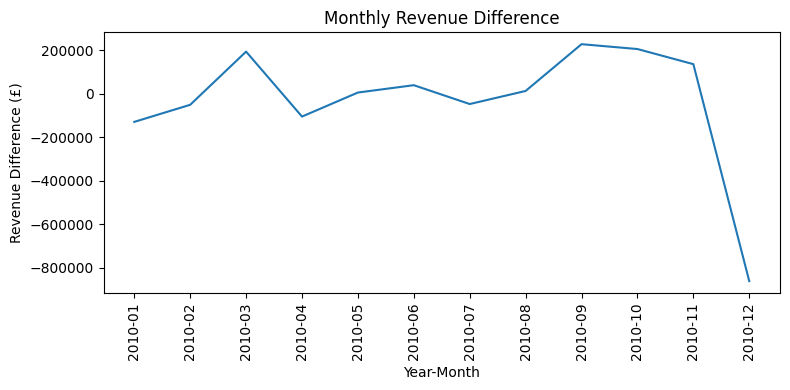

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(monthly_insights_df['month_year'], monthly_insights_df['difference'])
plt.title('Monthly Revenue Difference')
plt.xticks(rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Revenue Difference (£)')
plt.yscale("linear")
plt.tight_layout()
plt.show()

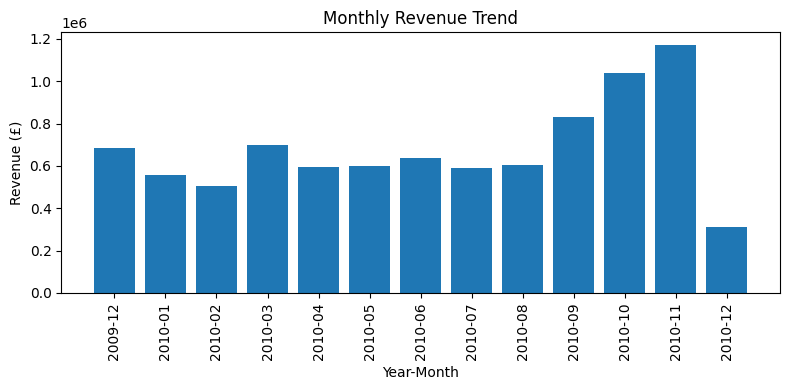

In [9]:
plt.figure(figsize=(8, 4))
plt.bar(monthly_insights_df['month_year'], monthly_insights_df['revenue'])
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Revenue (£)')
plt.yscale("linear")
plt.tight_layout()
plt.show()

In [10]:
weekly_insights_df = df.copy()
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekly_insights_df = weekly_insights_df.groupby(["weekday"])['revenue'].sum().reindex(weekday_order).reset_index()

weekly_insights_df

,weekday,revenue
0,Monday,1450261.395
1,Tuesday,1684044.201
2,Wednesday,1527283.523
3,Thursday,1864223.892
4,Friday,1272488.092
5,Saturday,9803.050
6,Sunday,1023899.121


In [12]:
# plt.figure(figsize=(8, 4))
# plt.bar(weekly_insights_df.index, weekly_insights_df.values, color='royalblue', edgecolor='black')
# plt.title('Revenue by Weekday', fontsize=14)
# plt.xticks(rotation=45)
# plt.xlabel('Weekday')
# plt.ylabel('Revenue (£)')
# plt.tight_layout()
# plt.show()


### 👥 Customer-Based Analysis — ‘Who makes us money?’

- “Who are the top 10% customers by lifetime revenue?”
- “How often do customers reorder?”
- “Which countries have the most valuable repeat customers?”
- “What does a typical high-value customer’s purchase pattern look like?”

In [13]:
# Invoice-level preprocessing

customer_insights_df = df.copy()
customer_insights_df = (
    df.groupby(["customer_id"], as_index=False)
      .agg({
          'revenue': 'sum',
          'invoice': 'nunique'
      })
)

customer_insights_df.sort_values(ascending=False, by="revenue")

customer_insights_df.describe()

,customer_id,revenue,invoice
count,4312.000000,4312.000000,4312.000000
mean,15349.290353,2048.238236,4.455705
std,1701.200176,8914.481280,8.170213
min,12346.000000,2.950000,1.000000
25%,13882.500000,307.987500,1.000000
50%,15350.500000,706.020000,2.000000
75%,16834.250000,1723.142500,5.000000
max,18287.000000,349164.350000,205.000000


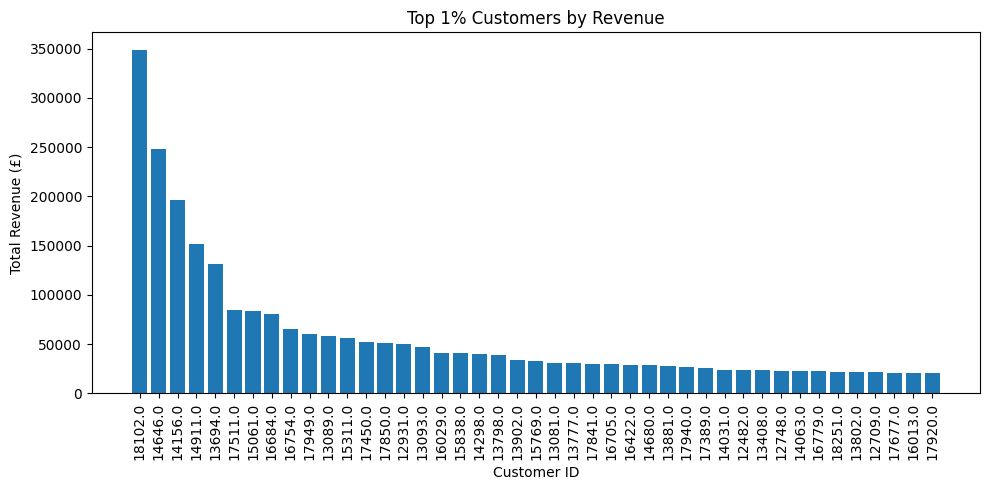

In [14]:
customer_insights_df = customer_insights_df.sort_values("revenue", ascending=False)
top_10_percent_cutoff = int(len(customer_insights_df) * 0.01)
top_customers_df = customer_insights_df.tail()
top_customers_df = customer_insights_df.head(top_10_percent_cutoff)

plt.figure(figsize=(10, 5))
plt.bar(top_customers_df["customer_id"].astype(str), top_customers_df["revenue"])
plt.xticks(rotation=90)
plt.title("Top 1% Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Total Revenue (£)")
plt.tight_layout()
plt.show()

### 📦 Product-Based Analysis — ‘What makes us money?’

- “Which products generate the most revenue vs. most orders?”
- “Are low-priced, high-quantity items masking true profit drivers?”
- “Are some products heavily discounted or returned?”
- “Which items often sell together?”

In [16]:
product_insights_df = df.copy()
product_insights_df

,invoice,stockcode,quantity,unitprice,customer_id,country,revenue,year,month,week_year,weekday
0,489434,85048,12,6.95,13085.0,United Kingdom,83.40,2009,12,49_2009,Tuesday
1,489434,79323P,12,6.75,13085.0,United Kingdom,81.00,2009,12,49_2009,Tuesday
2,489434,79323W,12,6.75,13085.0,United Kingdom,81.00,2009,12,49_2009,Tuesday
3,489434,22041,48,2.10,13085.0,United Kingdom,100.80,2009,12,49_2009,Tuesday
4,489434,21232,24,1.25,13085.0,United Kingdom,30.00,2009,12,49_2009,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
407659,538171,22271,2,2.95,17530.0,United Kingdom,5.90,2010,12,49_2010,Thursday
407660,538171,22750,1,3.75,17530.0,United Kingdom,3.75,2010,12,49_2010,Thursday
407661,538171,22751,1,3.75,17530.0,United Kingdom,3.75,2010,12,49_2010,Thursday
407662,538171,20970,2,3.75,17530.0,United Kingdom,7.50,2010,12,49_2010,Thursday


In [20]:
product_insights_df.merge(right=SKU_items, left_on='stockcode', right_on='stockcode')
product_insights_df

,invoice,stockcode,quantity,unitprice,customer_id,country,revenue,year,month,week_year,weekday
0,489434,85048,12,6.95,13085.0,United Kingdom,83.40,2009,12,49_2009,Tuesday
1,489434,79323P,12,6.75,13085.0,United Kingdom,81.00,2009,12,49_2009,Tuesday
2,489434,79323W,12,6.75,13085.0,United Kingdom,81.00,2009,12,49_2009,Tuesday
3,489434,22041,48,2.10,13085.0,United Kingdom,100.80,2009,12,49_2009,Tuesday
4,489434,21232,24,1.25,13085.0,United Kingdom,30.00,2009,12,49_2009,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
407659,538171,22271,2,2.95,17530.0,United Kingdom,5.90,2010,12,49_2010,Thursday
407660,538171,22750,1,3.75,17530.0,United Kingdom,3.75,2010,12,49_2010,Thursday
407661,538171,22751,1,3.75,17530.0,United Kingdom,3.75,2010,12,49_2010,Thursday
407662,538171,20970,2,3.75,17530.0,United Kingdom,7.50,2010,12,49_2010,Thursday


## Insights: